# Bayesian model selection

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Set the plotting style.
import sys
sys.path.insert(0, '../')
import mwc_mutants_utils as mwc
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Model selection between single parameter change and multiple parameters.

In this notebook we will explore the use of Bayesian model selection to distinguish between changes in the parameters that a single point mutation in the transcription factor can cause. Specifically we will be comparing two models:
1. $M_1$: A single family of parameters ($\Delta\varepsilon_{RA}$ for the DNA binding domain mutants and $K_A$ and $K_I$ for inducer binding pocket mutants) change when a single amino-acid substitution takes place on a specific part of the repressor.
2. $M_2$: All mutations in the transcription factor change all parameters having to do with the protein (except for $\Delta\varepsilon_{AI}$), i.e. $\Delta\varepsilon_{RA}$, $K_A$, and $K_I$.

The advantage of using Bayesian model selection is that intrinsically by the nature of the methodology 3 features are compared between models:
1. Prior information on how likely is each of the models to be true.
2. Goodness of fit of the model with the data.
3. Complexity of the model.

The framework then compares how well the model describes the data, but also how complicated is the model.

To see how these features are natually compared within the Bayesian framework we can write Bayes theorem for a model $M_i$ being true as
$$
P(M_i \mid D) = \frac{P(D \mid M_i) P(M_i)}{P(D)},
\tag{1}
$$
where $D$ is the data. In principle the denominator can be computed as
$$
P(D) = \sum_j P(D \mid M_j)P(M_j),
\tag{2}
$$
where we would have to sum over all possible models, making it impossible to ever compute the probability of a specific model being true. But we can instead compare two models $M_1$ and $M_2$. Since the denominator would be the same for both we can write
$$
\frac{P(M_1 \mid D)}{P(M_2 \mid D)} = \frac{P(D \mid M_1) P(M_i)}{P(D \mid M_2) P(M_i)}.
\tag{3}
$$

For a given model $M_i$ with parameters $\mathbf{a}_i$ we have that
$$
P(D \mid M_i) = \int d\mathbf{a}_i P(D \mid \mathbf{a}_i, M_i) P(\mathbf{a}_i \mid M_i)
\tag{4}
$$

In general this integral is not easy to compute analitically and one has to use parallel temporing MCMC (to be discussed later) to perform this integral numerically. But for cases where the posterior distribution of the parameters is single peaked and more or less symmetric (i.e. Gaussian-like) one can approximate the integral with the area of a rectangle. This simplification is known as the Laplace approximation and it is written as
$$
P(D \mid M_i) \approx P(\mathbf{a}_i^* \mid M_i) \underbrace{P(D \mid \mathbf{a}_i^*, M_i)}_\text{height} \underbrace{(2\pi)^{\vert \mathbf{a}_i \vert / 2} \sqrt{\det \boldsymbol{\sigma}_i^2}}_\text{width},
\tag{5}
$$
where $\mathbf{a}_i^*$ represents the most likely parameter values, $\vert \mathbf{a}_i \vert$ represents the number of parameters in the model, and $\boldsymbol{\sigma}_i$ is the covariance matrix that can be computed with the Gaussian approximation of the parameter posterior probability.

With this approximation we can write the odds ratio, i.e. the probability ratio between two models as
$$
O_{ij} = \underbrace{\left[ \frac{P(M_i)}{P(M_j)} \right]}_\text{prior on model}
\underbrace{\left[ \frac{P(D \mid \mathbf{a}_i^*, M_i)}{P(D \mid \mathbf{a}_j^*, M_j)} \right]}_\text{goodness of fit}
\underbrace{\left[ \frac{P(\mathbf{a}_i^* \mid M_i) (2\pi)^{\vert \mathbf{a}_i^* \vert / 2 } \sqrt{\det \boldsymbol{\sigma}_i^2}}{P(\mathbf{a}_j^* \mid M_j) (2\pi)^{\vert \mathbf{a}_j^* \vert / 2 } \sqrt{\det \boldsymbol{\sigma}_j^2}} \right]}_\text{Occam factor}.
\tag{6}
$$

This form of the odds ratio explicitly compares the 3 features mentioned above. For the Occam factor what it is accounting is the volume in parameter space in which the parameters can live. This naturally penalizes more complex models with many more parameters, giving a natural origin to [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor).

As usual when dealing with probabilities is easier to take the log. For the case of the Odds ratio we have
\begin{align}
\log O_{ij} &= \log \left[ \frac{P(M_i)}{P(M_j)} \right]\\
&+ \log P(D \mid \mathbf{a}_i^*, M_i) - \log P(D \mid \mathbf{a}_j^*, M_j)\\
&+ \log P(\mathbf{a}_i^* \mid M_i) - \log P(\mathbf{a}_j^* \mid M_j)\\
&+ \frac{\vert \mathbf{a}_i^* \vert  - \vert \mathbf{a}_j^* \vert}{2} \log 2\pi\\
&+ \frac{1}{2}\left( \log \boldsymbol{\sigma}_i^2 - \log \boldsymbol{\sigma}_j^2 \right)
\tag{7}
\end{align}

## DNA-binding domain mutants.

Let's work out the specific case for DNA-binding domain mutants in which
1. $M_1$ : only the $\Delta\varepsilon_{RA}$ is changed.
2. $M_2$ : $\Delta\varepsilon_{RA}$ along with $K_A$ and $K_I$ are changed.

We will assume that a priori both models are equally likely such that the first term of Eq. (7) is zero. We will also assume that each data point is independent of each other such that
$$
\log P(D \mid \mathbf{a}_i^*, M_i) = \sum_{d \in D} \log P(d \mid \mathbf{a}_i^*, M_i),
\tag{8}
$$
where $d$ is an individual data point of the dataset $D$.

We will assign a Gaussian likelihood with constant error across IPTG concentrations such that
\begin{align}
\sum_{d \in D} \log P(d \mid \mathbf{a}_i^*, {\sigma_i^*}, M_i) = 
&- \frac{n}{2} \log \left( 2 \pi  {\sigma_i^*}^2 \right) \\
&- \sum_{d \in D} \frac{\left( \text{fold-change}_{exp} - \text{fold-cange}_{thry}^{(d)}(\mathbf{a}_i^*)\right)^2}{2 {\sigma_i^*}^2},
\tag{9}
\end{align}
where $n = \vert D \vert$ is the number of data points, ${\sigma_i^*}$ is the most likely error associated with the Gaussian likelihood, $\text{fold-cange}_{exp}^{(d)}$ is the experimental fold change of the $d^{\text{th}}$ data point and $\text{fold-cange}_{thry}^{(d)}$ is the experimental prediction for the same datum.

Finally for the prior on the parameters we will assume uniform priors for $\Delta\varepsilon_{RA}$, $\tilde{k}_A \equiv -\log K_A / 1M$, and $\tilde{k}_I \equiv -\log K_I / 1M$, and a Jeffreys' prior for the $\sigma_i$ parameter associated with the Gaussian likelihood, obtaining
$$
\log P(\mathbf{a}_1^*, \sigma_1 \mid M_1) - \log P(\mathbf{a}_2^*, \sigma_2 \mid M_2) = \left[ \log P(\Delta\varepsilon_{RA} \mid M_1)  + \log P(\sigma_1 \mid M_1) \right]
- \left[ \log P(\Delta\varepsilon_{RA} \mid M_2) + \log P(\tilde{k_A} \mid M_2) + \log P(\tilde{k_I} \mid M_2) + \log P(\sigma_2 \mid M_2) \right].
\tag{10}
$$
Since for both models $\Delta\varepsilon_{RA}$ and $\sigma$ represent the same thing, the prior on these parameters should be the same so that those terms are canceled out. Since we stated that the parameters had a uniform prior we then can write this as
$$
\log P(\mathbf{a}_1^*, \sigma_1 \mid M_1) - \log P(\mathbf{a}_2^*, \sigma_2 \mid M_2) = \left[ \log \left( \tilde{k}_A^{\max} - \tilde{k}_A^{\min} \right) + \log \left( \tilde{k}_I^{\max} - \tilde{k}_I^{\min} \right) \right]
\tag{11}
$$

Putting all these terms together gives a log odds ratio
\begin{align}
\log O_{12} = &- \frac{n}{2} \log \left( 2 \pi  {\sigma_1^*}^2 \right)
- \sum_{d \in D} \frac{\left( \text{fold-change}_{exp} - \text{fold-cange}_{thry}^{(d)}({\Delta\varepsilon_{RA}}_1^*)\right)^2}{2 {\sigma_1^*}^2}\\
&- \frac{n}{2} \log \left( 2 \pi  {\sigma_2^*}^2 \right)
- \sum_{d \in D} \frac{\left( \text{fold-change}_{exp} - \text{fold-cange}_{thry}^{(d)}({\Delta\varepsilon_{RA}}_2^*, {\tilde{k}_A}_2^*, {\tilde{k}_I}_2^*) \right)^2}{2 {\sigma_2^*}^2}\\
&+ \log \left( \tilde{k}_A^{\max} - \tilde{k}_A^{\min} \right) + \log \left( \tilde{k}_I^{\max} - \tilde{k}_I^{\min} \right) \\
&+ \log 2\pi \\
&+ \frac{1}{2} \left( \log \det \boldsymbol{\sigma}_1^2 - \log \det \boldsymbol{\sigma}_2^2 \right),
\tag{12}
\end{align}
where $\boldsymbol{\sigma}_1^2$ is the covariance matrix for the two parameters for model $M_1$ ($\Delta\varepsilon_{RA}$ and $\sigma_1$) and $\boldsymbol{\sigma}_2$ is the covariance matrix for the four parameters for model $M_2$ ($\Delta\varepsilon_{RA}$, $\tilde{k}_A$, $\tilde{k}_I$, and $\sigma_2$)

##  Non-linear regression
In order to compute the log odds ratio we should be able to find the most likely parameters for each model and compute the covariance matrix at these parameters. To do so let's define the log posterior probability.

First let's define a function to compute the theoretical fold-change given a set of parameters and a given model.

In [33]:
def model_fold_change(param, indep_var, model):
    '''
    Computes the fold-change in gene expression for a series of parameters given
    two possible models:
    1: only the repressor-DNA binding energy is fit.
    2: the repressor-DNA binding energy along with the dissociation constants
       of the ligand are fit.
    Parameters
    ----------
    if model==1:
        param : float.
            param = epsilon_r.
    if model==2:
        param : array-like.
            param[0] = epsilon_r.
            param[1] = k_a == -log K_A.
            param[2] = k_i == -log K_I.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration.
        2nd column : repressor copy number.
    model : int.
        1 if only epsilon_r is fit
        2 if epsilon_r, k_A and k_I are fit
        
    Returns
    -------
    fold-change : float.
        fold-change in gene expression.
    '''
    # unpack independent variables
    IPTG, R = indep_var[:, 0], indep_var[:, 1]
    
    # compute the theoretical fold-change
    if model==1:
        # set fit parameters
        epsilon_r = param
        ka = -np.log(139.59)
        ki = -np.log(0.53)
        # compute theoretical fold-change
        fc_theory = mwc.fold_change_log(IPTG, ka, ki, 4.5, R, epsilon_r)
        
    elif model==2:
        # unpack parameters
        epsilon_r, ka, ki = param
        # compute theoretical fold-change
        fc_theory = mwc.fold_change_log(IPTG, ka, ki, 4.5, R, epsilon_r)
        
    else:
        raise ValueError('The only model options are 1 or 2')
        
    return fc_theory

Now let's define a function to compute the residuals between experimental and theoretical fold-change. This function will become handy when finding the most likely parameter values.

In [34]:
def resid(param, indep_var, dep_var, model):
    '''
    Computes the residuals between theoretical and experimental fold-change given
    two possible models:
    1: only the repressor-DNA binding energy is fit.
    2: the repressor-DNA binding energy along with the dissociation constants
       of the ligand are fit.
    Parameters
    ----------
    if model==1:
        param : float.
            param = epsilon_r.
    if model==2:
        param : array-like.
            param[0] = epsilon_r.
            param[1] = k_a == -log K_A.
            param[2] = k_i == -log K_I.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration.
        2nd column : repressor copy number.
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    model : int.
        1 if only epsilon_r is fit
        2 if epsilon_r, k_A and k_I are fit
        
    Returns
    -------
    residual : array-like.
        residuals between theory and experiment
    '''
    return dep_var - model_fold_change(param, indep_var, model)

Now let's define functions to compute the log posterior of the parameter estimation problem.

Firts the log likelihood and the log prior.

In [118]:
def log_likelihood(param, indep_var, dep_var, model):
    '''
    Computes the log likelihood for a Gaussian likelihood given two models
    two possible models:
    1: only the repressor-DNA binding energy is fit.
    2: the repressor-DNA binding energy along with the dissociation constants
       of the ligand are fit.
    Parameters
    ----------
    if model==1:
        param : float.
            param[0] = epsilon_r.
            param[1] = sigma (error associated with Gaussian likelihood)
    if model==2:
        param : array-like.
            param[0] = epsilon_r.
            param[1] = k_a == -log K_A.
            param[2] = k_i == -log K_I.
            param[3] = sigma (error associated with Gaussian likelihood)
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration.
        2nd column : repressor copy number.
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    model : int.
        1 if only epsilon_r is fit
        2 if epsilon_r, k_A and k_I are fit
        
    Returns
    -------
    log_likelihoood : float.
        The log likelihood for the parameters given the data and a model
    '''
    sigma = param[-1]
    model_param = param[:-1]
    
    return -np.sum(resid(model_param, indep_var, dep_var, model)**2)\
                   / 2 / sigma**2 \
                - len(indep_var) / 2 * np.log(2 * np.pi * sigma**2)

def log_prior(param, bounds, model):
    '''
    Computes the log prior given two models two possible models:
    1: only the repressor-DNA binding energy is fit.
    2: the repressor-DNA binding energy along with the dissociation constants
       of the ligand are fit.
    All of these parameters are assumed to have uniform priors except for the
    sigma parameter that is assumed to have a Jeffreys' prior
    Parameters
    ----------
    if model==1:
        param : float.
            param[0] = epsilon_r.
            param[1] = sigma (error associated with Gaussian likelihood)
        bounds : array-like.
            lower and upper bound for epsilon_r
    if model==2:
        param : array-like.
            param[0] = epsilon_r.
            param[1] = k_a == -log K_A.
            param[2] = k_i == -log K_I.
            param[3] = sigma (error associated with Gaussian likelihood)
        bounds : list.
            bounds[0] = lower and upper bound for epsilon_r
            bounds[1] = lower and upper bound for k_a
            bounds[2] = lower and upper bound for k_i
    model : int.
        1 if only epsilon_r is fit
        2 if epsilon_r, k_A and k_I are fit
        
    Returns
    -------
    log_prior : float.
        The log prior for the parameters given the data and a model
    '''
    if model==1:
        # unpack parameters
        epsilon_r, sigma = param
        epsilon_min, epsilon_max = bounds
        if (sigma < 0) or \
           (epsilon_r < epsilon_min) or \
           (epsilon_r > epsilon_max):
            return -np.inf
        else:
            return -np.log(sigma) - np.log(epsilon_max - epsilon_min)
        
    elif model==2:
        # unpack parameters
        epsilon_r, ka, ki, sigma = param
        epsilon_bounds = bounds[0]
        ka_bounds = bounds[1]
        ki_bounds = bounds[2]
        if (sigma < 0) or \
           (epsilon_r < epsilon_bounds[0]) or \
           (epsilon_r > epsilon_bounds[1]) or \
           (ka < ka_bounds[0]) or \
           (ka > ka_bounds[1]) or \
           (ki < ki_bounds[0]) or \
           (ki > ki_bounds[1]):
            return -np.inf
        else:
            return -np.log(sigma) -np.log(np.abs(np.diff(epsilon_bounds)))\
                   -np.log(np.abs(np.diff(ka_bounds)))\
                   -np.log(np.abs(np.diff(ki_bounds)))

Now let's put these terms together and compute the log posterior 

In [164]:
def log_posterior(param, bounds, indep_var, dep_var, model):
    '''
    Computes the log likelihood for a Gaussian likelihood given two models
    two possible models:
    1: only the repressor-DNA binding energy is fit.
    2: the repressor-DNA binding energy along with the dissociation constants
       of the ligand are fit.
    Parameters
    ----------
    if model==1:
        param : float.
            param = epsilon_r.
        bounds : array-like.
            lower and upper bound for epsilon_r
    if model==2:
        param : array-like.
            param[0] = epsilon_r.
            param[1] = k_a == -log K_A.
            param[2] = k_i == -log K_I.
            param[3] = sigma (error associated with Gaussian likelihood)
        bounds : list.
            bounds[0] = lower and upper bound for epsilon_r
            bounds[1] = lower and upper bound for k_a
            bounds[2] = lower and upper bound for k_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration.
        2nd column : repressor copy number.
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    model : int.
        1 if only epsilon_r is fit
        2 if epsilon_r, k_A and k_I are fit
        
    Returns
    -------
    log_posterior : float.
        The log posterior for the parameters given the data and a model
    '''
    lp = log_prior(param, bounds, model)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(param, indep_var, dep_var, model)

def neg_logposterior(param, bounds, indep_var, dep_var, model):
    return -log_posterior(param, bounds, indep_var, dep_var, model)

Time to test these functions. Let's load up the data and perform some regressions!

In [120]:
# Read the CSV file with the mean fold change
df = pd.read_csv('../../data/flow_master.csv',index_col=0 , comment='#')
df = df[(df.strain!='auto') & (df.strain!='delta')]
df.head()

,date,username,operator,class,strain,repressors,IPTG_uM,mean_YFP,mean_YFP_bgcorr,fold_change
24,20170303,mrazomej,O2,dna,Q21A,260,0.1,10207.801372,6061.418830,0.219585
25,20170303,mrazomej,O2,dna,Q21A,260,0.0,9536.491380,5220.269553,0.278905
26,20170303,mrazomej,O2,dna,Q21A,260,1000.0,20307.551849,16127.546380,0.970668
27,20170303,mrazomej,O2,dna,Q21A,260,100.0,19769.723730,15746.672950,0.913559
28,20170303,mrazomej,O2,dna,Q21A,260,10.0,10745.853106,6788.125747,0.369471


Let's start with the O2 Q21M strain.

In [179]:
# Extract the data
df_example = df[(df.operator=='O2') & (df.strain=='Q21A')]

# Define the independent variables
indep_var = df_example[['IPTG_uM', 'repressors']]
dep_var = df_example.fold_change

#### Model 1

In [180]:
# Initial guess
p0 = np.array([-10, 1])

# define the model and the bounds for the parameter
bounds_1 = [-20, 0]
model = 1
# Extra arguments given as tuple 
args_1 = (bounds_1, indep_var.values, dep_var.values, model)

# Compute the MAP 
res = scipy.optimize.minimize(neg_logposterior, p0, args=args_1, 
                                  method='powell', tol=1E-10)
popt_1 = res.x
cov_1 = -np.linalg.inv(smnd.approx_hess(popt_1, log_posterior, args=args_1))

/Users/razo/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


#### Model 2

In [181]:
# Initial guess
p0 = np.array([-10, -np.log(139.59), -np.log(0.53), 1])

# define the model and the bounds for the parameter
bounds_2 = [[-20,  0], [-7, 7], [-7, 7]]
model = 2
# Extra arguments given as tuple 
args_2 = (bounds_2, indep_var.values, dep_var.values, model)

# Compute the MAP 
res = scipy.optimize.minimize(neg_logposterior, p0, args=args_2, 
                                  method='powell', tol=1E-10)
popt_2 = res.x
cov_2 = -np.linalg.inv(smnd.approx_hess(popt_2, log_posterior, args=args_2))

/Users/razo/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in multiply
  tmp2 = (x - v) * (fx - fw)


Let's look at how well the fit looks for this data set

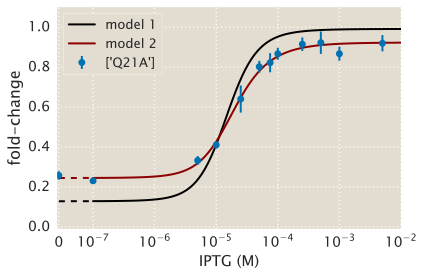

In [182]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

ka = -np.log(139.59)
ki = -np.log(0.53)

# Initialize the plot to set the size
fig, ax = plt.subplots(1, 1)
# compute the mean value for each concentration
fc_mean = df_example.groupby('IPTG_uM').fold_change.mean()
# compute the standard error of the mean
fc_err = df_example.groupby('IPTG_uM').fold_change.std() / \
np.sqrt(df_example.groupby('IPTG_uM').size())
ax.errorbar(np.sort(df_example.IPTG_uM.unique()) / 1E6,
        fc_mean, yerr=fc_err, fmt='o', 
        label= df_example.strain.unique(), zorder=100)

# Plot theoretical prediction
#### MODEL 1 ###
# Log scale
ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
    ea=ka, ei=ki, epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_r=popt_1[0]),
    color='black', label='model 1')
# # Linear scale
ax.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
    ea=ka, ei=ki, epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_r=popt_1[0]),
    linestyle='--', color='black', label=None)
#### MODEL 2 ###
# Log scale
ax.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
    ea=popt_2[1], ei=popt_2[2], epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_r=popt_2[0]),
    color='darkred', label='model 2')
# # Linear scale
ax.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
    ea=popt_2[1], ei=popt_2[2], epsilon=4.5,
    R=df_example.repressors.unique()[0],
    epsilon_r=popt_2[0]),
    linestyle='--', color='darkred', label=None)

ax.set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
ax.set_xlabel('IPTG (M)', fontsize=15)
ax.set_ylabel('fold-change', fontsize=16)
ax.set_ylim([-0.01, 1.1])
ax.set_xlim(left=-5E-9)
ax.tick_params(labelsize=14)
ax.legend(loc='upper left')
plt.tight_layout()

Let's now define 2 functions:
1. To compute the log goodness of fit ratio
2. To compute the log occam factor

In [173]:
def log_goodness_fit(popt_1, popt_2, args_1, args_2):
    '''
    Computes the log goodness of fit ratio given two sets of parameters.
    
    Parameters
    ----------
    popt_1, popt_2 : array-like
        array containing the MAP values for the free parameters in model 1 and
        model 2
    args_1, args_2 : list.
        list containing the extra arguments to be passed to the log-likelihood
        function
    
    Returns
    -------
    the log goodnes of fit ratio
    '''
    return log_likelihood(popt_1, *args_1) - log_likelihood(popt_2, *args_2)

def log_occam(popt_1, popt_2, bounds_1, bounds_2, cov_1, cov_2):
    '''
    Computes the log occam factor given two sets of covariance matrices.
    
    Parameters
    ----------
    popt_1, popt_2 : array-like
        array containing the MAP values for the free parameters in model 1 and
        model 2
    bounds_1, bounds_2: list.
        lists containing the bounds on the priors
    cov_1, cov_2 : array-like
        covariance matrices evaluated at the MAP
    
    Returns
    -------
    the log occam factor
    '''
    log_prior_1 = log_prior(popt_1, bounds_1, 1)
    log_prior_2 = log_prior(popt_2, bounds_2, 2)
    return log_prior_1 - log_prior_2 - (np.log(2 * np.pi) + \
           np.log(np.linalg.det(cov_1)) - np.log(np.linalg.det(cov_2))) / 2

In [174]:
args_1 = (indep_var.values, dep_var.values, 1)
args_2 = (indep_var.values, dep_var.values, 2)
log_good_fit = log_goodness_fit(popt_1, popt_2, args_1, args_2)
print('Goodness of fit ratio:', np.exp(log_good_fit))

Goodness of fit ratio: 0.014508475986


In [175]:
log_occam_factor = log_occam(popt_1, popt_2, bounds_1, bounds_2, cov_1, cov_2)
print('Occam factor:', np.exp(log_occam_factor))

Occam factor: [ 5.99835006]


In [176]:
np.exp(log_good_fit + log_occam_factor)

array([ 0.08702692])

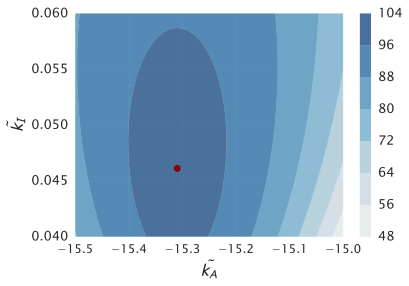

In [171]:
# Parameter values to plot
epsilon_array = np.linspace(-15.5, -15, 100)
sigma_array = np.linspace(0.04, 0.06, 100)

# make a grid to plot
ee, ss = np.meshgrid(epsilon_array, sigma_array)

# compute the log posterior

log_post_mat = np.empty_like(ee)
for i in range(len(epsilon_array)):
    for j in range(len(sigma_array)):
        log_post_mat[i, j] = log_posterior(np.array([ee[i, j], ss[i, j]]),
                                            bounds_1,
                                       indep_var.values, dep_var.values, 1)

# Get things to scale better
# log_post_mat -= log_post_mat.max()

# plot the results
plt.figure()
plt.contourf(ee, ss, log_post_mat, alpha=0.7,
             cmap=plt.cm.Blues)
plt.colorbar()
plt.plot(popt_1[0], popt_1[1], marker='o', color='darkred')
plt.xlabel(r'$\tilde{k_A}$')
plt.ylabel(r'$\tilde{k_I}$')
# plt.title('Posterior probability, O2 - RBS1027')